# Line Segment Intersection Exercises

**1.** Implement an algorithm that finds intersection points from the set of line segments $S$ in $O((n+k)logn)$, where $n$ is the number of segments and $k$ is the number of intersection points. 

For starters, we need to define two datastructures that are used in the output-sensitive sweep line algorithm that calculates intersection points: __event queue__ and __status structure__.

Event queue is a balanced binary tree that stores event points of the sweep line algorithm for finding intersection points in the set of line segments $S$. In Python, this will be a Python dictionary with Point2D objects that already has the comparator function implemented.

A status structure is a little trickier for implementation, since it needs to store line segments that crosses the current state of the sweep line. This comparator has to be dependent on the event point to store line segments in order.

First, we need to generate some line segments and test our event queue.

In [1]:
import matplotlib.pyplot as plt
from comgeo.plane import Point2D, DirectedEdge
import random

# number of line segments
N = 4

min_val = 2
max_val = 5

def generate_segments(number_of_segments, min_val, max_val):
    segment_list = list()

    for i in range(number_of_segments):
        x1 = random.random() * (max_val - min_val) + min_val
        y1 = random.random() * (max_val - min_val) + min_val
        x2 = random.random() * (max_val - min_val) + min_val
        y2 = random.random() * (max_val - min_val) + min_val

        begin = Point2D(x1, y1)
        end = Point2D(x2, y2)

        segment_list.append(DirectedEdge(begin, end))
        
    return segment_list
    
def plot_segments(segment_list):
    for segment in segment_list:
        plt.plot([segment.begin.x, segment.end.x], [segment.begin.y, segment.end.y])

We will develop a function that calculates the intersection point of type Point2D if they are intersecting. If they are not, it will return None, since there is no intersection. Let's check the simplest algorithm in $O(n^2)$ for finding segment intersections just we can see later if algorithm computes all the intersection points:

In [2]:
def calculate_intersection(segment_1, segment_2):
    if not segment_1.is_intersecting(segment_2) or segment_1.is_collinear(segment_2):
        # If segments are collinear, we don't cover cases with infinite solutions
        # If segments are not intersecting, we won't calculate them
        return None
    
    x1 = segment_1.begin.x
    y1 = segment_1.begin.y
    
    x2 = segment_1.end.x
    y2 = segment_1.end.y
    
    x3 = segment_2.begin.x
    y3 = segment_2.begin.y
    
    x4 = segment_2.end.x
    y4 = segment_2.end.y
    
    # Slopes
    if x2 - x1 == 0 and x4 - x3 == 0:
        if x1 == x3 or x1 == x4:
            return segment_1.begin
        elif x2 == x3 or x2 == x4:
            return segment_2.end
        
        return None
    elif x2 - x1 == 0:
        m2 = (y4 - y3) / (x4 - x3)
        
        intersection_x = x2
        intersection_y = m2 * (x2 - x3) + y3 
        
        return Point2D(intersection_x, intersection_y)
    
    elif x4 - x3 == 0:
        m1 = (y2 - y1) / (x2 - x1)
        
        intersection_x = x3
        intersection_y = m1 * (x3 - x1) + y1
        
        return Point2D(intersection_x, intersection_y)
    
    m1 = (y2 - y1) / (x2 - x1)
    m2 = (y4 - y3) / (x4 - x3)
    
    # Test if collinear
    if m1 == m2:
        return None
    
    intersection_x = (y3 - y1 + m1 * x1 - m2 * x3) / (m1 - m2)
    intersection_y = m1 * (intersection_x - x1) + y1
    
    return Point2D(intersection_x, intersection_y)

def find_intersection_quadratic(segment_list):
    intersections = set()
    for i in range(len(segment_list)):
        for j in range(i + 1, len(segment_list)):
            intersection = calculate_intersection(segment_list[i], segment_list[j])
            
            if intersection:
                intersections.add(intersection)
            
    return intersections

In [3]:
def scatter_points(points):
    counter = 1
    for point in points:
        plt.scatter(point.x, point.y)
        plt.annotate(s=str(counter), xy=(point.x, point.y + 0.2), ha="center")
        counter += 1

7


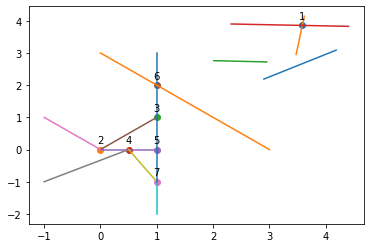

In [4]:
segment_list = generate_segments(N, min_val, max_val)

segment_list.append(DirectedEdge(Point2D(0, 0), Point2D(1, 0)))
segment_list.append(DirectedEdge(Point2D(0, 0), Point2D(1, 1)))
segment_list.append(DirectedEdge(Point2D(0, 0), Point2D(-1, 1)))
segment_list.append(DirectedEdge(Point2D(0.5, 0), Point2D(-1, -1)))
segment_list.append(DirectedEdge(Point2D(0.5, 0), Point2D(1, -1)))
segment_list.append(DirectedEdge(Point2D(1, -1), Point2D(1, -2)))
segment_list.append(DirectedEdge(Point2D(1, -1), Point2D(1, 3)))
segment_list.append(DirectedEdge(Point2D(0, 3), Point2D(3, 0)))

intersections = find_intersection_quadratic(segment_list)

print(len(intersections))

plot_segments(segment_list)
scatter_points(intersections)

plt.show()

Now we need to develop an event queue:

In [5]:
# TODO: Srediti access modifiere
# public modifier za python klasa je bez underscore-a (e.g. public)
# protected je sa jednim underscore-om (e.g. _protected)
# private je sa duplim underscore-om (e.g. __private)

class NodeBST():
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        self.height = 1
    
    def __str__(self):
        return "Node({}, {})".format(self.value, self.height)

def height(nodeBST):
    if nodeBST == None:
        return 0
    return nodeBST.height
    
class BalancedBST():
    def __init__(self):
        self.root = None
        
    def is_empty(self):
        return False if self.root else True
    
    def __balance(self, root):
        if root == None:
            return None
        
        left_height = height(root.left)
        right_height = height(root.right)
        
        if abs(left_height - right_height) > 1:
            
            if left_height > right_height:
                left_left_height = height(root.left.left)
                left_right_height = height(root.left.right)
                
                if left_left_height > left_right_height:
                    root = self.__rotate_right(root)
                else:
                    root = self.__rotate_left_right(root)
            
            else:
                right_left_height = height(root.right.left)
                right_right_height = height(root.right.right)
                
                if right_right_height > right_left_height:
                    root = self.__rotate_left(root)
                else:
                    root = self.__rotate_right_left(root)
        
        return root
                    
            
    def __rotate_right(self, root):
        temp_left_right = root.left.right
        temp_left = root.left
        
        root.left.right = root
        root.left = temp_left_right
        root = temp_left
        
        root.right.height = max(height(root.right.left), height(root.right.right)) + 1
        root.height = max(height(root.left), height(root.right)) + 1
        
        return root
    
    def __rotate_left(self, root):
        temp_right_left = root.right.left
        temp_right = root.right
        
        root.right.left = root
        root.right = temp_right_left
        root = temp_right
        
        root.left.height = max(height(root.left.left), height(root.left.right)) + 1
        root.height = max(height(root.left), height(root.right)) + 1
        
        return root
    
    def __rotate_left_right(self, root):
        root.left = self.__rotate_left(root.left)
        root = self.__rotate_right(root)
        
        return root
    
    def __rotate_right_left(self, root):
        root.right = self.__rotate_right(root.right)
        root = self.__rotate_left(root)
        
        return root
    
    def __recursive_insert(self, root, value):
        if value <= root.value and root.left:
            root.left = self.__recursive_insert(root.left, value)
        elif value >= root.value and root.right:
            root.right = self.__recursive_insert(root.right, value)
        elif value <= root.value:
            root.left = NodeBST(value)
        else:
            root.right = NodeBST(value)
            
        left_height = height(root.left)
        right_height = height(root.right)
        
        root.height = max(left_height, right_height) + 1
        
        root = self.__balance(root)
        
        return root
        
    def insert(self, value):
        if self.root == None:
            self.root = NodeBST(value)
        else:
            self.root = self.__recursive_insert(self.root, value)
    
    def __recursive_delete_node(self, value, root):
        if root == None:
            return None
        
        if(value < root.value):
            root.left = self.__recursive_delete_node(value, root.left)
        elif(root.value < value):
            root.right = self.__recursive_delete_node(value, root.right)
        elif(root.left and root.right):
            root.value = self._recursive_find_min(root.right)
            root.right = self.__recursive_delete_node(root.value, root.right)
        else:
            old_node = root
            root = root.left if root.left else root.right
            root = self.__balance(root)
            return root
        
        root = self.__balance(root)
        return root
    
    def delete_node_first(self, value):
        root = self.__recursive_delete_node(value, self.root)

        self.root = root
    
    def _recursive_find_min(self, root):
        if root == None:
            return None
        
        if root.left:
            return self._recursive_find_min(root.left)
        else:
            return root.value
    
    def _recursive_find_max(self, root):
        if root == None:
            return None
        
        if root.right:
            return self._recursive_find_max(root.right)
        else:
            return root.value
        
    def find_min(self):
        return self._recursive_find_min(self.root)
    
    def find_max(self):
        return self._recursive_find_min(self.root)
    
    def pop_min(self):
        minimum = self._recursive_find_min(self.root)
        self.root = self.__recursive_delete_node(minimum, self.root)
        
        return minimum
    
    def __recursive_find(self, root, value):
        if root == None:
            return False
        elif root.value == value:
            return True
        elif value < root.value:
            return self.__recursive_find(root.left, value)
        else:
            return self.__recursive_find(root.right, value)
    
    def find(self, value):
        return self.__recursive_find(self.root, value)
    
    def __preorder(self, root, func):
        if root:
            func(root)
            self.__preorder(root.left, func)
            self.__preorder(root.right, func)
    
    def preorder(self, func):
        self.__preorder(self.root, func)
    
    def __inorder(self, root, func):
        if root:
            self.__inorder(root.left, func)
            func(root)
            self.__inorder(root.right, func)
    
    def inorder(self, func):
        self.__inorder(self.root, func)
        
    def __postorder(self, root, func):
        if root:
            self.__postorder(root.left, func)
            self.__postorder(root.right, func)
            func(root)
        
    def postorder(self, func):
        self.__postorder(self.root, func)
        

In [6]:
for segment in segment_list:
    print(segment)

DirectedEdge(Point2D(4.184819234526105, 3.0880341791249553), Point2D(2.9022735014510124, 2.1893150162167156))
DirectedEdge(Point2D(3.4746189654353046, 2.9542502246730393), Point2D(3.6189963178912956, 4.141662731355401))
DirectedEdge(Point2D(2.9519003717116856, 2.7225303597914605), Point2D(2.012460008729918, 2.761398241287889))
DirectedEdge(Point2D(4.405084160795308, 3.8275767365406814), Point2D(2.321657281601145, 3.900801122540482))
DirectedEdge(Point2D(0, 0), Point2D(1, 0))
DirectedEdge(Point2D(0, 0), Point2D(1, 1))
DirectedEdge(Point2D(0, 0), Point2D(-1, 1))
DirectedEdge(Point2D(0.5, 0), Point2D(-1, -1))
DirectedEdge(Point2D(0.5, 0), Point2D(1, -1))
DirectedEdge(Point2D(1, -1), Point2D(1, -2))
DirectedEdge(Point2D(1, -1), Point2D(1, 3))
DirectedEdge(Point2D(0, 3), Point2D(3, 0))


In [7]:
# Event Queue
class EventPoint(Point2D):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.segments = dict()
    
    def add_segment(self, label, segment):
        if label not in self.segments:
            self.segments[label] = list()
        
        self.segments[label].append(segment)
    
    def __str__(self):
        to_string = "EventPoint({}, {})".format(self.x, self.y) + ", Segments: ["
        
        for label, segment in self.segments.items():
            to_string += "{} - {}, ".format(label, segment)
        
        if(len(self.segments)):
            to_string = to_string[:-2]
        
        to_string += "]"
        
        return to_string

In [8]:
class EventQueue(BalancedBST):
    def add_event_point(self, event_point):
        if self.find(event_point):
            curr_node = self.root
            
            # Finding the existing event point
            while curr_node.value != event_point:
                curr_node = curr_node.left if event_point < curr_node.value else curr_node.right
            
            for label, segment in event_point.segments.items():
                curr_node.value.add_segment(label, segment)
        else:
            self.insert(event_point)
            
    def __recursive_copy(self, root, copy):
        if root == None:
            return copy
        
        copy.add_event_point(root.value)
        copy = self.__recursive_copy(root.left, copy)
        copy = self.__recursive_copy(root.right, copy)
        
        return copy

    def next_event(self):
        minimum = self.pop_min()
        
        return minimum
    
    def copy(self):
        """Returns the copy of the Event Queue"""
        copy = EventQueue()
        
        return self.__recursive_copy(self.root, copy)

In [9]:
UPPER = "U"
INTERSECTION = "C"
LOWER = "L"

def get_initial_event_queue(segment_list):

    event_queue = EventQueue()

    for segment in segment_list:
        upper_endpoint = min(segment.begin, segment.end)
        upper_event_point = EventPoint(upper_endpoint.x, upper_endpoint.y)
        upper_event_point.add_segment(UPPER, segment)

        lower_endpoint = max(segment.begin, segment.end)
        lower_event_point = EventPoint(lower_endpoint.x, lower_endpoint.y)
        lower_event_point.add_segment(LOWER, segment)

        event_queue.add_event_point(upper_event_point)
        event_queue.add_event_point(lower_event_point)
    
    return event_queue
    

event_queue = get_initial_event_queue(segment_list)
print("\nPreorder:")
event_queue.preorder(print)


Preorder:
Node(EventPoint(2.012460008729918, 2.761398241287889), Segments: [U - [DirectedEdge(Point2D(2.9519003717116856, 2.7225303597914605), Point2D(2.012460008729918, 2.761398241287889))]], 5)
Node(EventPoint(1, -2), Segments: [U - [DirectedEdge(Point2D(1, -1), Point2D(1, -2))]], 4)
Node(EventPoint(0, 0), Segments: [U - [DirectedEdge(Point2D(0, 0), Point2D(1, 0)), [DirectedEdge(Point2D(0, 0), Point2D(1, 1))]], L - [[DirectedEdge(Point2D(0, 0), Point2D(-1, 1))]]], 3)
Node(EventPoint(-1, 1), Segments: [U - [DirectedEdge(Point2D(0, 0), Point2D(-1, 1))]], 2)
Node(EventPoint(-1, -1), Segments: [U - [DirectedEdge(Point2D(0.5, 0), Point2D(-1, -1))]], 1)
Node(EventPoint(0.5, 0), Segments: [L - [DirectedEdge(Point2D(0.5, 0), Point2D(-1, -1))], U - [[DirectedEdge(Point2D(0.5, 0), Point2D(1, -1))]]], 2)
Node(EventPoint(0, 3), Segments: [U - [DirectedEdge(Point2D(0, 3), Point2D(3, 0))]], 1)
Node(EventPoint(1, 0), Segments: [L - [DirectedEdge(Point2D(0, 0), Point2D(1, 0))]], 3)
Node(EventPoint(

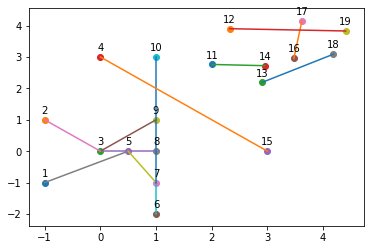

In [10]:
copy_queue = event_queue.copy()

points = list()

while not copy_queue.is_empty():
    next_event = copy_queue.next_event()
    points.append(next_event)
    
scatter_points(points)
plot_segments(segment_list)

In [11]:
test_segments = list()

test_segments.append(DirectedEdge(Point2D(-2, 2), Point2D(3, 4)))
test_segments.append(DirectedEdge(Point2D(3, -2), Point2D(-3, 1)))
test_segments.append(DirectedEdge(Point2D(-3, -2), Point2D(0, -1)))

test_queue = get_initial_event_queue(test_segments)

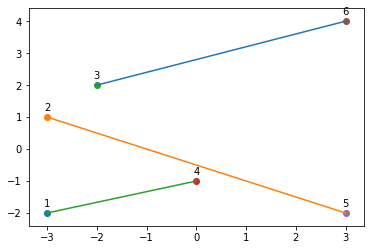

In [12]:
test_points = list()

copy_test_queue = test_queue.copy()

while not copy_test_queue.is_empty():
    next_event = copy_test_queue.next_event()
    test_points.append(next_event)

plot_segments(test_segments)
scatter_points(test_points)

In [21]:
class SegmentStatusPair():
    def __init__(self, segment, reference_point):
        self.segment = segment
        self.reference_point = reference_point
        
    def evaluate_Y(self, reference_point):
        if self.segment.end.x - self.segment.begin.x != 0:
            m = (self.segment.end.y - self.segment.begin.y)/(self.segment.end.x - self.segment.begin.x)
            return m * (reference_point.x - self.segment.begin.x) + self.segment.begin.y
        else:
            return max(self.segment.begin.y, self.segment.end.y)
    
    def __le__(self, segment_status_pair):
        reference_point = max(self.reference_point, segment_status_pair.reference_point)
        return self.evaluate_Y(reference_point) <= segment_status_pair.evaluate_Y(reference_point)
    
    def __eq__(self, segment_status_pair):
        reference_point = max(self.reference_point, segment_status_pair.reference_point)
        return self.evaluate_Y(reference_point) == segment_status_pair.evaluate_Y(reference_point)
    
    def __neq__(self, segment_status_pair):
        return not self == segment_status_pair
    
    def __lt__(self, segment_status_pair):
        return self <= segment_status_pair and self != segment_status_pair
    
    def __gt__(self, segment_status_pair):
        return not self <= segment_status_pair
    
    def __ge__(self, segment_status_pair):
        return not self < segment_status_pair
    
    def __str__(self):
        return "Segment Status Pair({})".format(self.segment)

class SegmentStatusStructure(BalancedBST):
    def add_segment_status_pair(self, segment, reference_point):
        segment_status_pair = SegmentStatusPair(segment, reference_point)
        self.insert(segment_status_pair)
        
    def _delete_segment(self, root, segment_status_pair):
        if root == None:
            return
        
        if root.value.segment == segment_status_pair.segment:
            self.delete_node_first(root.value)
            return
        
        if segment_status_pair < root.value:
            self._delete_segment(root.left, segment_status_pair)
        elif root.value < segment_status_pair:
            self._delete_segment(root.right, segment_status_pair)
        else:
            self._delete_segment(root.left, segment_status_pair)
            self._delete_segment(root.right, segment_status_pair)
        
    def delete_segment(self, segment, event_point):
        segment_status_pair = SegmentStatusPair(segment, event_point)
        
        self._delete_segment(self.root, segment_status_pair)
        
    
    def __find(self, root, value):
        if root == None:
            return None
        
        if value < root.value:
            return self.__find(root.left, value)
        elif root.value < value:
            return self.__find(root.right, value)
        else:
            return root
    
    # TODO: Pronaci lijeve i desne najblize komsije, ako postoje
    def nearest_left_neighbor(self, event_point):
        left_neighbor = None
        
        curr_node = self.root
        
        while curr_node.left and curr_node.left.value.segment.orientation(event_point) == -1:
            curr_node = root.left
    
    def nearest_right_neighbor(self, segment_status_pair):
        pass       

U-(-3, -2)
Node(Segment Status Pair(DirectedEdge(Point2D(-3, -2), Point2D(0, -1))), 1)

U-(-3, 1)
Node(Segment Status Pair(DirectedEdge(Point2D(-3, -2), Point2D(0, -1))), 2)
Node(Segment Status Pair(DirectedEdge(Point2D(3, -2), Point2D(-3, 1))), 1)

U-(-2, 2)
Node(Segment Status Pair(DirectedEdge(Point2D(-3, -2), Point2D(0, -1))), 1)
Node(Segment Status Pair(DirectedEdge(Point2D(3, -2), Point2D(-3, 1))), 2)
Node(Segment Status Pair(DirectedEdge(Point2D(-2, 2), Point2D(3, 4))), 1)

L-(0, -1)
Node(Segment Status Pair(DirectedEdge(Point2D(3, -2), Point2D(-3, 1))), 2)
Node(Segment Status Pair(DirectedEdge(Point2D(-2, 2), Point2D(3, 4))), 1)

L-(3, -2)
Node(Segment Status Pair(DirectedEdge(Point2D(-2, 2), Point2D(3, 4))), 1)

L-(3, 4)



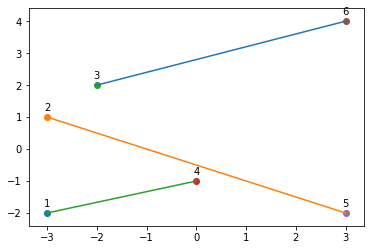

In [22]:
def handle_event_point(event_point, status_structure):
    for label, segments in event_point.segments.items():
        print("{}-({}, {})".format(label, event_point.x, event_point.y))
        
        if label == UPPER:
            for segment in segments:
                status_structure.add_segment_status_pair(segment, event_point)
        elif label == LOWER:
            for segment in segments:
                status_structure.delete_segment(segment, event_point)
        elif label == INTERSECTION:
            for segment in segments:
                status_structure.delete_segment(segment, event_point)
                status_structure.add_segment_status_pair(segment, event_point)
    
    return status_structure

copy_test_queue = test_queue.copy()
status_structure = SegmentStatusStructure()

plot_segments(test_segments)
scatter_points(test_points)

while not copy_test_queue.is_empty():
    next_event = copy_test_queue.next_event()
    
    status_structure = handle_event_point(next_event, status_structure)
    
    status_structure.inorder(print)
    print()

In [ ]:
a = DirectedEdge(Point2D(-3, -2), Point2D(0, -1))
b = DirectedEdge(Point2D(-3, -2), Point2D(0, -1))

a == b